In [2]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

1.9.1+cpu
0
False


In [4]:
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

In [5]:
dataroot = "../input/track1data/track1data/"
ckptroot = "./"

lr = 1e-4
weight_decay = 1e-5
batch_size = 32
num_workers = 8
test_size = 0.8
shuffle = True

epochs = 80
start_epoch = 0
resume = False

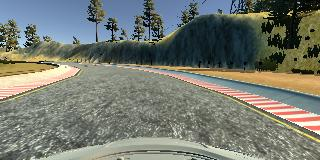

In [6]:
Image(filename='/kaggle/input/selfdriving-car-simulator/track1data/track1data/IMG/center_2019_04_02_19_25_33_671.jpg') 

In [7]:
class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper."""

    def __init__(self):
        """Initialize NVIDIA model.

        NVIDIA model used
            Image normalization to avoid saturation and make gradients work better.
            Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Drop out (0.5)
            Fully connected: neurons: 100, activation: ELU
            Fully connected: neurons: 50, activation: ELU
            Fully connected: neurons: 10, activation: ELU
            Fully connected: neurons: 1 (output)

        the convolution layers are meant to handle feature engineering
        the fully connected layer for predicting the steering angle.
        """
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 2 * 33, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output


# Define model
print("==> Initialize model ...")
model = NetworkNvidia()
print("==> Initialize model done ...")

==> Initialize model ...
==> Initialize model done ...


In [8]:
model = NetworkNvidia()

In [9]:
criterion = nn.MSELoss()

In [10]:
teslamodel = torch.load("/kaggle/input/model80/both-nvidia-model-80.h5", map_location=lambda storage, loc: storage)
start_epoch = teslamodel['epoch']
model.load_state_dict(teslamodel['state_dict'])

<All keys matched successfully>

In [11]:
model.eval()

NetworkNvidia(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4224, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [12]:
def toDevice(datas, device):
    """Enable cuda."""
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)

def augment(dataroot, imgName, angle):
    """Data augmentation."""
    current_image = cv2.imread('/kaggle/input/selfdriving-car-simulator/track1data'+imgName)
    current_image = current_image[65:-25, :, :]
    return current_image, angle

In [13]:
import scipy
from scipy import signal
data_df = pd.read_csv(os.path.join('/kaggle/input/selfdriving-car-simulator/track1data/track1data/', 'driving_log.csv'),
                          names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
data_df["steering"] = signal.savgol_filter(data_df["steering"].values.tolist(), 51, 11)
data_df['center'] = data_df['center'].str.replace("\\",'/')
data_df['center'] = data_df['center'].str.slice(7,)
data_df['left'] = data_df['left'].str.replace("\\",'/')
data_df['left'] = data_df['left'].str.slice(7,)
data_df['right'] = data_df['right'].str.replace("\\",'/')
data_df['right'] = data_df['right'].str.slice(7,)
data_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,center,left,right,steering,throttle,reverse,speed
0,/track1data/IMG/center_2019_04_02_19_25_33_671...,/track1data/IMG/left_2019_04_02_19_25_33_671.jpg,/track1data/IMG/right_2019_04_02_19_25_33_671.jpg,-0.007504,0.000000,0,0.000011
1,/track1data/IMG/center_2019_04_02_19_25_33_743...,/track1data/IMG/left_2019_04_02_19_25_33_743.jpg,/track1data/IMG/right_2019_04_02_19_25_33_743.jpg,0.013752,0.000000,0,0.000007
2,/track1data/IMG/center_2019_04_02_19_25_33_816...,/track1data/IMG/left_2019_04_02_19_25_33_816.jpg,/track1data/IMG/right_2019_04_02_19_25_33_816.jpg,0.004956,0.000000,0,0.000003
3,/track1data/IMG/center_2019_04_02_19_25_33_887...,/track1data/IMG/left_2019_04_02_19_25_33_887.jpg,/track1data/IMG/right_2019_04_02_19_25_33_887.jpg,-0.006112,0.048016,0,0.002267
4,/track1data/IMG/center_2019_04_02_19_25_33_959...,/track1data/IMG/left_2019_04_02_19_25_33_959.jpg,/track1data/IMG/right_2019_04_02_19_25_33_959.jpg,-0.010181,0.281203,0,0.175589


In [14]:
testset = data_df.values.tolist()
testset[0]

['/track1data/IMG/center_2019_04_02_19_25_33_671.jpg',
 '/track1data/IMG/left_2019_04_02_19_25_33_671.jpg',
 '/track1data/IMG/right_2019_04_02_19_25_33_671.jpg',
 -0.00750443986372867,
 0.0,
 0,
 1.058134e-05]

# Calculating Test Accuracy Using the Center Camera only

In [15]:
class CenterDataset(data.Dataset):

    def __init__(self, dataroot, samples, transform=None):
        self.samples = samples
        self.dataroot = dataroot
        self.transform = transform

    def __getitem__(self, index):
        batch_samples = self.samples[index]
        steering_angle = float(batch_samples[3])

        center_img, steering_angle_center = augment(self.dataroot, batch_samples[0], steering_angle)
        left_img, steering_angle_left     = augment(self.dataroot, batch_samples[1], steering_angle + 0.4)
        right_img, steering_angle_right   = augment(self.dataroot, batch_samples[2], steering_angle - 0.4)

        center_img = self.transform(center_img)
        left_img   = self.transform(left_img)
        right_img  = self.transform(right_img)

        return (center_img, steering_angle_center)

    def __len__(self):
        return len(self.samples)

In [26]:
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 127.5) - 1.0)])
test_set = CenterDataset(dataroot, testset, transformations)
testloader = DataLoader(test_set,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=4)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
num_correct = 0
total = 0
model.eval()
with torch.no_grad():
    for imgs, angles in testloader:
        imgs = imgs.float().to(device)
        angles = angles.float().to(device)
        outputs = model(imgs)
        angles = angles.unsqueeze(1)
        num_correct += ((outputs-angles)<0.1).sum()
        total += angles.size(0)
    print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")

Test Accuracy of the model: 78.20


# Calculating Test Accuracy Using all the 3 Cameras

In [20]:
class TripletDataset(data.Dataset):

    def __init__(self, dataroot, samples, transform=None):
        self.samples = samples
        self.dataroot = dataroot
        self.transform = transform

    def __getitem__(self, index):
        batch_samples = self.samples[index]
        steering_angle = float(batch_samples[3])

        center_img, steering_angle_center = augment(self.dataroot, batch_samples[0], steering_angle)
        left_img, steering_angle_left     = augment(self.dataroot, batch_samples[1], steering_angle + 0.4)
        right_img, steering_angle_right   = augment(self.dataroot, batch_samples[2], steering_angle - 0.4)

        center_img = self.transform(center_img)
        left_img   = self.transform(left_img)
        right_img  = self.transform(right_img)

        return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)

    def __len__(self):
        return len(self.samples)

In [55]:
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 127.5) - 1.0)])
test_set = TripletDataset(dataroot, testset, transformations)
testloader = DataLoader(test_set,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=4)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
num_correct = 0
total = 0
model.eval()
with torch.no_grad():
    for loaders in testloader:
        for imgs, angles in loaders:
            imgs = imgs.float().to(device)
            angles = angles.float().to(device)
            outputs = model(imgs)
            angles = angles.unsqueeze(1)
            num_correct += ((outputs-angles)<0.1).sum()
            total += angles.size(0)
    print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")

Test Accuracy of the model: 71.01
